## Structural Causal Models and Parameters

## Lab 03 for PH 290: Targeted Learning in Biomedical Big Data

### Author: [Nima Hejazi](https://nimahejazi.org)

### Date: 31 January 2018

### Attribution: adapted from source materials by [David Benkeser](https://www.benkeserstatistics.com/)

In [1]:
options(repr.plot.width = 4, repr.plot.height = 3)  ## resizing plots
options(scipen = 999)  ## has scientific notation ever annoyed you?
library(tidyverse)
library(ggsci)
set.seed(76548208)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.7.2.9000     ✔ stringr 1.2.0.9000
✔ readr   1.1.1          ✔ forcats 0.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## I. Introduction

In this lab, we review how to simulate from structural causal models (SCMs) and how to approximate causal parameters based on SCMs. We also illustrate how to compare causal parameters to observed data parameters to verify identifiability results discussed in class.

Consider the data structure $X = (W_1,W_2,A,Y)$ and $U = (U_{W,1}, U_{W,2},U_{A},U_Y)$. The first exercise will show how to explicitly simulate data from a structural model. Our causal model stipulates that $(U,X) \sim P_{U,X}$ for some $P_{U,X} \in \mathcal{M}^X$, a model that assumes that $U_A \perp U_Y$, but otherwise makes no assumptions about the distribution of $(U,X)$. One (of many) such $P_{U,X}$ that is in this model is given by the error distributions \begin{align*}
U_{W,1} &\sim \mbox{Bernoulli}(1/2) \\
U_{W,2} &\sim \mbox{Bernoulli}(1/2) \\
U_A &\sim \mbox{Normal}(0,1) \\
U_Y &\sim \mbox{Normal}(0,1) \ ,
\end{align*}
and structural equations \begin{align*}
f_{W,1}(U_{W,1}) &= U_{W,1} \\
f_{W,2}(U_{W,2}) &= U_{W,2} \\
f_A(W_1, W_2, U_A) &= I(\mbox{expit}(W_1 - W_2 + U_A) > 0.5)\\
f_Y(W_1, W_2, A, U_Y) &= -W_1 + W_2 + A - U_Y \ . 
\end{align*}

Let's think about how we can explicity code this distribution in R. Let's first write a function to represent each structural equation.

In [2]:
# structural equation for W_1
# takes as input a vector U_W1 and returns a vector evaluating
# f_{W,1}(U_W1)
f_W1 <- function(U_W1){
    return(U_W1)
}

# structural equation for W_2
# takes as input a vector U_W2 and returns a vector evaluating
# f_{W,2}(U_W2)
f_W2 <- function(U_W2){
    return(U_W2)
}

# structural equation for A
f_A <- function(W_1, W_2, U_A){
    return(as.numeric(plogis(W_1 - W_2 + U_A) > 0.5))
}

# structural equation for Y
f_Y <- function(W_1, W_2, A, U_Y){
    return(-W_1 + W_2 + A - U_Y)
}

We can now define a function to generate an observation from this SCM.

In [3]:
sim_obs_scm <- function(n) {
    ##############################################
    # function to draw n observations from an scm
    # n = the number of observations to draw
    # returns a data.frame with named columns
    ##############################################

    # first we draw the errors
    ## draw U_{W,1}
    U_W1 <- rbinom(n,1,0.5)
    ## draw U_{W,2}
    U_W2 <- rbinom(n,1,0.5)
    ## draw U_A
    U_A <- rnorm(n,0,1)
    ## draw U_Y
    U_Y <- rnorm(n,0,1)

    # now we can evaluate the observations sequentially
    ## evaluate W_1
    W_1 <- f_W1(U_W1)
    ## evaluate W_2
    W_2 <- f_W2(U_W2)
    ## evaluate A
    A <- f_A(W_1 = W_1, W_2 = W_2, U_A = U_A)
    ## evaluate Y
    Y <- f_Y(W_1 = W_1, W_2 = W_2, A = A, U_Y = U_Y)

    # return a tibble
    out <- as_tibble(list(W_1 = W_1, W_2 = W_2, A = A, Y = Y))
    return(out)
}

# try it out 
sim_test <- sim_obs_scm(n = 100)
head(sim_test)

W_1,W_2,A,Y
0,0,1,1.3935595
1,0,0,-0.1991701
1,1,0,-0.7243135
0,0,0,-0.6034721
0,0,1,2.7803916
1,0,1,0.7458899


The above function generates a set of $n$ observations that might be observed in pratice were this $P_{X,U}$ to be the true data generating distribution. Because we are simulating the data, we can also perform manipulations on this SCM, as we would like to (but may be unable to) do in practice. 

Let's now define a function that allows us to set the value of $A$ to either 0 or 1 and returns a data set of counterfactual observations, i.e., observations we would have seen if we were able to manipulate the SCM. 

In [4]:
sim_int_scm <- function(n, set_A = 1) {
    #########################################################
    # function that draws n observations from an SCM that is 
    #   intervened on to set A = set_A
    # n = number of observations
    # set_A = the value to set A equal to (0 or 1)
    # returns a tibble of coutnerfactual observations
    #########################################################

    # first we draw the errors
    ## draw U_{W,1}
    U_W1 <- rbinom(n,1,0.5)
    ## draw U_{W,2}
    U_W2 <- rbinom(n,1,0.5)
    ## draw U_A
    U_A <- rnorm(n,0,1)
    ## draw U_Y
    U_Y <- rnorm(n,0,1)

    # now we can evaluate the observations sequentially
    ## evaluate W_1
    W_1 <- f_W1(U_W1)
    ## evaluate W_2
    W_2 <- f_W2(U_W2)
    # we are now setting A = 1 for everyone
    A <- rep(set_A, n)
    ## evaluate Y with the set values of A
    Y <- f_Y(W_1 = W_1, W_2 = W_2, A = A, U_Y = U_Y)

    # return a tibble object
    out <- as_tibble(list(W_1 = W_1, W_2 = W_2, A = A, Y = Y) )
    ## lets rename the Y column to reflect the intervention
    colnames(out)[4] <- paste0("Y_",set_A)
    return(out)
}

# try it out
sim_test_a_is_1 <- sim_int_scm(n = 100, set_A = 1)
head(sim_test_a_is_1)

# and with setA = 0
sim_test_a_is_0 <- sim_int_scm(n = 100, set_A = 0)
head(sim_test_a_is_0)

W_1,W_2,A,Y_1
0,1,1,1.3922722
1,1,1,1.8913405
1,1,1,-0.3918730
1,1,1,1.7296904
1,1,1,2.0408356
1,1,1,-0.4072731


W_1,W_2,A,Y_0
1,0,0,-0.3711431
1,1,0,-0.8501863
0,0,0,0.6210759
1,1,0,1.6312533
0,0,0,-1.5470715
1,1,0,-1.5102034


Let's think about the distribution of the counterfactual random variables $Y_a, a = 0,1$ implied by an intervention on the SCM setting $A=a$. We can use a large sample to approximate this distribution and plot an approximation with a histogram.

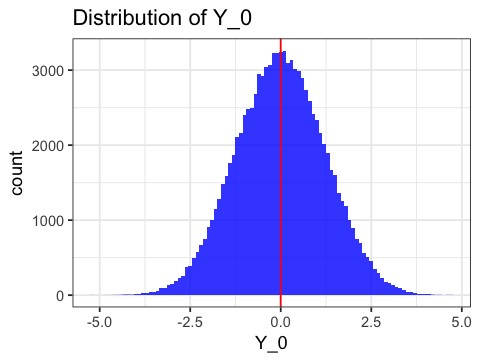

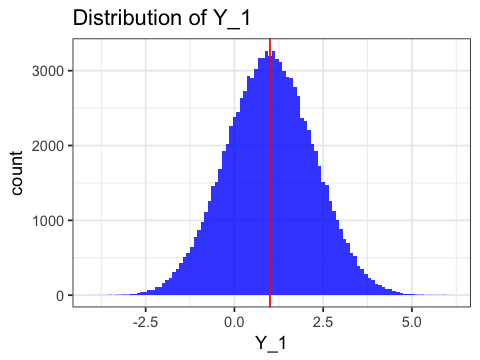

In [5]:
# simulate a big data set from he SCM on which we intervened to set A = 0
big_int_0 <- sim_int_scm(n = 1e5, set_A = 0)

# plot the distribution of Y_0
p_y0 <- ggplot(big_int_0, aes(x = Y_0)) +
  geom_histogram(aes(y = ..count..), fill = "blue", binwidth = 0.1, alpha = 0.8) +
  theme_bw() +
  xlab("Y_0") +
  ggtitle("Distribution of Y_0")

# simulate a big data set from the SCM on which we intervened to set A = 1
big_int_1 <- sim_int_scm(n = 1e5, set_A = 1)

# plot the distribution of Y_1
p_y1 <- ggplot(big_int_1, aes(x = Y_1)) +
  geom_histogram(aes(y = ..count..), fill = "blue", binwidth = 0.1, alpha = 0.8) +
  theme_bw() +
  xlab("Y_1") +
  ggtitle("Distribution of Y_1")

# approximate the (counterfactual) mean of Y_0
cf_mean_y0 <- mean(big_int_0$Y_0)
## let's add it to the histogram
p_y0 <- p_y0 + geom_vline(xintercept = cf_mean_y0, colour = "red")
p_y0

# approximate the (counterfactual) mean of Y_1
cf_mean_y1 <- mean(big_int_1$Y_1)
## let's add it to the histogram
p_y1 <- p_y1 + geom_vline(xintercept = cf_mean_y1, colour = "red")
p_y1

Consider computing the average treatment effect under $P_{U,X}$, $$
\Psi_{cf}(P_{U,X}) = E_{P_{U,X}}\{ f_Y(w_1, w_2, 1, u_Y) - E_{P_{U,X}}\{f_Y(w_1, w_2, 0, u_Y) \} \ . 
$$
This quantity can be approximated using our simulated values as follows:

In [6]:
cf_mean_y1 - cf_mean_y0

[1] 1.003207

Now let's take a look at the distribution of the observed $Y$ implied by this SCM. In particular, let's consider the distribution of $Y$ conditional on $A=a$ for $a=0,1$. A conditional distribution is nothing more than the distribution of a variable in a subset of the population. Here that subset is defined by the observed treatment level.

[1] 0.3364178

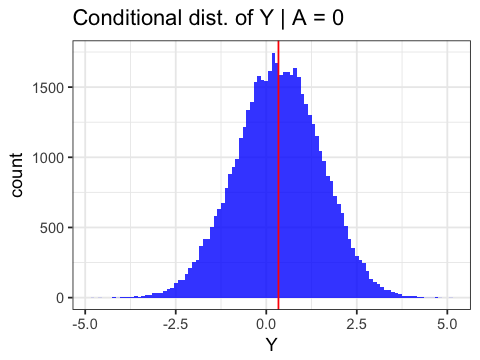

[1] 0.6568714

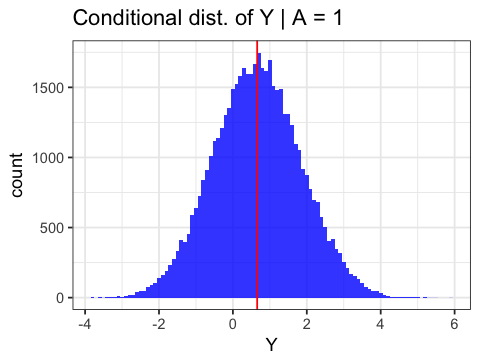

In [7]:
# simulate large data set
big_obs <- sim_obs_scm(n = 1e5)

# plot a histogram of the conditional distribution of Y given A = 0 
py_a_is_0 <- big_obs %>%
  dplyr::filter(A == 0) %>%
  ggplot(., aes(x = Y)) +
    geom_histogram(aes(y = ..count..), fill = "blue", binwidth = 0.1, alpha = 0.8) +
    theme_bw() +
    xlab("Y") +
    ggtitle("Conditional dist. of Y | A = 0")

# plot a histogram of the conditional distribution of Y given A = 1
py_a_is_1 <- big_obs %>%
  dplyr::filter(A == 1) %>%
  ggplot(., aes(x = Y)) +
    geom_histogram(aes(y = ..count..), fill = "blue", binwidth = 0.1, alpha = 0.8) +
    theme_bw() +
    xlab("Y") +
    ggtitle("Conditional dist. of Y | A = 1")

# approximate the conditional mean of Y | A = 0 
cond_mean_Y0 <- big_obs %>%
  dplyr::filter(A == 0) %>%
  summarise(mean(Y)) %>%
  as.numeric()
## let's add it to the histogram
py_a_is_0 <- py_a_is_0 + geom_vline(xintercept = cond_mean_Y0, colour = "red")
py_a_is_0
cond_mean_Y0

# approximate the conditional mean of Y | A = 0 
cond_mean_Y1 <- big_obs %>%
  dplyr::filter(A == 1) %>%
   summarise(mean(Y)) %>%
   as.numeric()
## let's add it to the histogram
py_a_is_1 <- py_a_is_1 + geom_vline(xintercept = cond_mean_Y1, colour = "red")
py_a_is_1
cond_mean_Y1

When we take the mean of the large ("infinite") data set we are approximating the parameter $$ 
E_P(Y \mid A = a)
$$
with $$
\frac{1}{N_a}\sum\limits_{i : A_i = a} Y_i \ ,
$$
where $N_a$ is the number of observations with $A = a$. If $n$ is chosen to be very large, this approximation should be very close to the true integral. 

Consider the parameter that I'll call the "naive causal effect":
$$
\Psi_{naive}(P) = E_P(Y \mid A=1) - E_P(Y \mid A=0)
$$
Having evaluated the above code, we can approximate the value of the parameter at this particular $P$ as follows:

In [8]:
cond_mean_Y1 - cond_mean_Y0

[1] 0.3204535

We see that the naive causal effect does not equal the true causal effect even at this effectively infinite sample size. That is, the parameter $\Psi_{naive}$ does not identify $\Psi_{cf}$. This should come as no surprise, as we can see that there is confounding in this example. That is, $W_1$ and $W_2$ affect both the probability of having $A = 1$, as well as the value of the outcome $Y$. Let's now explicity confirm that the parameter
$$
\Psi(P) = E\{E(Y \mid A=1, W) - E(Y \mid A=0, W)\}
$$
does indeed identify the causal effect.

In [9]:
# write a loop to get mean of Y | A = 1, W = w minus
# mean of Y | A = 0, W = w in each strata of W
out <- NULL
for (w1 in c(0, 1)) {
    for (w2 in c(0, 1)) {
        ate_this_W <- with(big_obs,
            mean(Y[A == 1 & W_1 == w1 & W_2 == w2]) -
                mean(Y[A == 0 & W_1 == w1 & W_2 == w2])
            )
        p_this_W <- with(big_obs,
            sum(W_1 == w1 & W_2 == w2) / nrow(big_obs)
            )
        out <- rbind(out, c(ate_this_W, p_this_W))
    }
}
out <- as_tibble(out)
colnames(out) <- c("ate_w","p_w")

# let's look at the matrix we just made
out

ate_w,p_w
1.0222572,0.24952
1.0205086,0.24973
0.9859355,0.25136
1.0020733,0.24939


The matrix `out` contains a column that shows the average treatment effect in each strata, as well as the proportion of observations falling in that strata. A few observations stand out:

- The average causal effect in each strata is equal to the overall average causal effect. Why? 

- The proportion falling in each strata is approximately equal. Why?

We can use these values to get back the overall causal effect:

In [10]:
sum(out$ate_w * out$p_w)

[1] 1.007657

## III. Optimal Treatment Rules

Let's consider a slight modification of the first example
\begin{align*}
U_{W,1} &\sim \mbox{Bernoulli}(1/2) \\
U_{W,2} &\sim \mbox{Bernoulli}(1/2) \\
U_A &\sim \mbox{Normal}(0,1) \\
U_Y &\sim \mbox{Normal}(0,1) \ ,
\end{align*}
and structural equations \begin{align*}
f_{W,1}(U_{W,1}) &= U_{W,1} \\
f_{W,2}(U_{W,2}) &= U_{W,2} \\
f_A(W_1, W_2, U_A) &= I(\mbox{expit}(W_1 - W_2 + U_A) > 0.5)\\
f_Y(W_1, W_2, A, U_Y) &= 2W_1 - 3 W_1W_2 A + W_2 A - A + U_Y\ . 
\end{align*}

In [11]:
# this uses the same functions defined in section I above
# for f_W1, f_W2, f_A, but we need to re-define f_Y
f_Y <- function(W_1, W_2, A, U_Y) {
    W_1 + W_2 - W_1 * W_2 * A + 3 * W_2 * A - A + U_Y
}

Here, we will study intervening in a graph according to a specified treatment rule. There are four possible covariate strata: $(W_1, W_2) \in \{ (0,0), (0,1), (1,0), (1,1) \}$.

Let's define a new variable
$$
W_S = f_S(W_1, W_2) = I(W_1 = 0, W_2 = 0) + 2 I(W_1 = 0, W_2 = 1) + 3 I(W_1 = 1, W_2 = 0) + 4 I(W_1 = 1, W_2 = 1) \ . 
$$

We are interested in the optimal treatment rule, which corresponds to picking a subset of the strata to treat. Let's write a function that can simulate from an intervened SCM according to a specified rule.

In [12]:
sim_rule_int_scm <- function(n, strata_tx) {
    ################################################################
    # define a function that takes as input
    # n = the number of observations to simulate
    # strataTrt = the values of W_s to treat 
    # return a tibble according to the rule-specific intervened SCM 
    ################################################################

    # first we draw the errors
    ## draw U_{W,1}
    U_W1 <- rbinom(n, 1, 0.5)
    ## draw U_{W,2}
    U_W2 <- rbinom(n, 1, 0.5)
    ## draw U_A
    U_A <- rnorm(n, 0, 1)
    ## draw U_Y
    U_Y <- rnorm(n, 0, 1)

    # now we can evaluate the observations sequentially
    ## evaluate W_1
    W_1 <- f_W1(U_W1)
    ## evaluate W_2
    W_2 <- f_W2(U_W2)
    ## evaluate W_S
    W_S <- as.numeric(I(W_1 == 0 & W_2 == 0) + 2 * I(W_1 == 0 & W_2 == 1) + 
        3 * I(W_1 == 1 & W_2 == 0) + 4 * I(W_1 == 1 & W_2 == 1))
    # set A according to strataTrt
    A <- as.numeric(W_S %in% strata_tx)

    # evaluate Y with the set values of A
    Y <- f_Y(W_1 = W_1, W_2 = W_2, A = A, U_Y = U_Y)

    # return a tibble object
    out <- as_tibble(list(W_1 = W_1, W_2 = W_2, W_S = W_S, A = A, Yd = Y) )
    return(out)
}

# simulate data treating strata 1
rule_only_1 <- sim_rule_int_scm(n = 100, strata_tx = 1)
# let's take a look
head(rule_only_1)

# confirm that anyone with W_S == 1 has A = 1
all(rule_only_1$A[rule_only_1$W_S == 1] == 1)
# and that anyone without W_S == 1 has A = 0 
all(rule_only_1$A[rule_only_1$W_S != 1] == 0)

W_1,W_2,W_S,A,Yd
0,0,1,1,-1.7828683
0,0,1,1,-0.8844762
1,0,3,0,0.3308235
0,1,2,0,1.6771381
0,0,1,1,-1.9609462
1,0,3,0,2.0303488


[1] TRUE

[1] TRUE

We can now perform a grid search to determine the optimal treatment rule under this distribution.

In [13]:
# first create a list that contains all possible 
# subsets of strata. We do this using the combn function
strata_list <- vector(mode = "list", length = 0)
for(i in seq_len(max(rule_only_1$W_S))){
    strata_list <- c(strata_list, 
        combn(1:4, i, simplify = FALSE))
}

# you can look at the list to see what this command
# did (omitted here for space)
#strata_list

# write a function that computes E(Y_d)
get_EYd <- function(strata, n = 1e5) {
    # simulate data according to rule
    dat <- sim_rule_int_scm(n = n, strata_tx = strata)
    # calculate mean of Yd
    return(mean(dat$Yd))
}

# apply the function over strataList
all_EYd <- unlist(lapply(strata_list, get_EYd))
# look at all the values for E(Y_d)
all_EYd
# optimal rule is the smallest value of E(Y_d)
opt_index <- which(all_EYd == min(all_EYd))
# what rule is it 
strata_list[opt_index]

[1] 0.7446407 1.4955317 0.7463059 1.2503903 1.2544166 0.5017744 0.9953844
 [8] 1.2468752 1.7472405 1.0026003 1.0048200 1.4989603 0.7539236 1.4998641
[15] 1.2403954

[[1]]
[1] 1 3

Now let's confirm the identification result given in the notes. We can define a function to simulate observed data from the SCM, that is, without intervening:

In [14]:
sim_rule_obs_scm <- function(n) {
    # first we draw the errors
    ## draw U_{W,1}
    U_W1 <- rbinom(n, 1, 0.5)
    ## draw U_{W,2}
    U_W2 <- rbinom(n, 1, 0.5)
    ## draw U_A
    U_A <- rnorm(n, 0, 1)
    ## draw U_Y
    U_Y <- rnorm(n, 0, 1)

    # now we can evaluate the observations sequentially
    ## evaluate W_1
    W_1 <- f_W1(U_W1)
    ## evaluate W_2
    W_2 <- f_W2(U_W2)
    ## evaluate W_S
    W_S <- as.numeric(I(W_1 == 0 & W_2 == 0) + 2 * I(W_1 == 0 & W_2 == 1) + 
        3 * I(W_1 == 1 & W_2 == 0) + 4 * I(W_1 == 1 & W_2 == 1))
    # evaluate A according to f_A 
    A <- f_A(W_1 = W_1, W_2 = W_2, U_A = U_A)

    # evaluate Y with the set values of A
    Y <- f_Y(W_1 = W_1, W_2 = W_2, A = A, U_Y = U_Y)

    ## return a data.frame object
    out <- data.frame(W_1 = W_1, W_2 = W_2, W_S = W_S, A = A, Y = Y) 
    return(out)
}

We now can simulate data from the observed data distribution implied by $P_{U,X}$. Recall from class that the optimal rule could be defined as $I(B_0(W) > 0)$, where $$
B_0(W) = E(Y \mid A=1, W) - E(Y \mid A=0, W)
$$ 
is the "BLIP" function. Let's now write a function that simulates a large observed data set and computes the BLIP function in each strata.

In [15]:
get_blip <- function(strata, n = 1e6) {
    # simulate data based on rule
    dat <- sim_rule_obs_scm(n = n)
    
    EY_A1_WS <- dat %>%
      dplyr::filter(W_S %in% strata & A == 1) %>%
      summarise(mean(Y)) %>%
      as.numeric()
    
    EY_A0_WS <- dat %>%
      dplyr::filter(W_S %in% strata & A == 0) %>%
      summarise(mean(Y)) %>%
      as.numeric()

    blip <- EY_A1_WS - EY_A0_WS 
    return(blip)
}

# now compute the blip for each strata
all_blips <- unlist(lapply(split(1:4, 1:4), get_blip))
all_blips

# which strata have blip < 0
as.numeric(which(all_blips < 0))

1          2          3          4 
-0.9990978  1.9964276 -0.9948048  1.0006289

[1] 1 3